# 3D Houses Project

##### A jupyter notebook where you can search for a Belgium address and it will create a 3D House model using Lidar.

### Enter Belgium Address

First you need to enter the Belgium address you wanted to search.

In [4]:
address = input("Enter the Belgium address: ") 

Enter the Belgium address: Sint-Hubertusstraat 89, 2600 Antwerpen


### Importing The Necessary Libraries

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import plotly.graph_objects as go

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import requests
import json

# set this so the graphs open internally
%matplotlib inline

import rioxarray as rxr
import rasterio as rt
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box

ModuleNotFoundError: No module named 'plotly'

### Getting The Coordinates Of The Address

Now that we got the address, we are going to check the address in the www.geopunt.be website to check if the input address is a valid address in Vlaanderen and to get the coordinates. 

In [6]:
req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()

In [23]:
req['LocationResult'][0]['BoundingBox']

{'LowerLeft': {'Lat_WGS84': 51.196053437224585,
  'Lon_WGS84': 4.412926976848,
  'X_Lambert72': 153087.56,
  'Y_Lambert72': 209564.97},
 'UpperRight': {'Lat_WGS84': 51.196053437224585,
  'Lon_WGS84': 4.412926976848,
  'X_Lambert72': 153087.56,
  'Y_Lambert72': 209564.97}}

In [24]:
address_info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'latitude' : req['LocationResult'][0]['Location']['Lat_WGS84'], 
                'longitude' : req['LocationResult'][0]['Location']['Lon_WGS84'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality'],
                'bbox' : req['LocationResult'][0]['BoundingBox']}

In [25]:
address_info

{'address': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
 'x_value': 153087.56,
 'y_value': 153087.56,
 'latitude': 51.196053437224585,
 'longitude': 4.412926976848,
 'street': 'Sint-Hubertusstraat',
 'house_number': '89',
 'postcode': '2600',
 'municipality': 'Antwerpen',
 'bbox': {'LowerLeft': {'Lat_WGS84': 51.196053437224585,
   'Lon_WGS84': 4.412926976848,
   'X_Lambert72': 153087.56,
   'Y_Lambert72': 209564.97},
  'UpperRight': {'Lat_WGS84': 51.196053437224585,
   'Lon_WGS84': 4.412926976848,
   'X_Lambert72': 153087.56,
   'Y_Lambert72': 209564.97}}}

### Checking the Polygon of the address by using the API

Now, we have to look for the address in the Basisregisters Vlaanderen API and get the polygon of that address.

Here is the link to the API: https://docs.basisregisters.dev-vlaanderen.be/docs/api-documentation.html#operation/GetAddress

In [132]:
r = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", params={"postcode": address_info['postcode'], "straatnaam": address_info['street'], "huisnummer": address_info['house_number'] })
file = json.loads(r.content)
file

{'adresMatches': [{'identificator': {'id': 'https://data.vlaanderen.be/id/adres/235907',
    'naamruimte': 'https://data.vlaanderen.be/id/adres',
    'objectId': '235907',
    'versieId': '2014-07-05T05:25:34+02:00'},
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/adressen/235907',
   'gemeente': {'objectId': '11002',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/gemeenten/11002',
    'gemeentenaam': {'geografischeNaam': {'spelling': 'Antwerpen',
      'taal': 'nl'}}},
   'postinfo': {'objectId': '2600',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/postinfo/2600'},
   'straatnaam': {'objectId': '2623',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/straatnamen/2623',
    'straatnaam': {'geografischeNaam': {'spelling': 'Sint-Hubertusstraat',
      'taal': 'nl'}}},
   'huisnummer': '89',
   'volledigAdres': {'geografischeNaam': {'spelling': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
     'taal': 'nl'}},
   'adresPositie': {'point': {'coord

In [135]:
r = requests.get(file['adresMatches'][0]['adresseerbareObjecten'][0]['detail'])
gebouwheden = json.loads(r.content)
gebouwheden

{'identificator': {'id': 'https://data.vlaanderen.be/id/gebouweenheid/16269194',
  'naamruimte': 'https://data.vlaanderen.be/id/gebouweenheid',
  'objectId': '16269194',
  'versieId': '2017-02-16T17:32:10+01:00'},
 'geometriePunt': {'point': {'coordinates': [153087.56, 209564.97],
   'type': 'Point'}},
 'positieGeometrieMethode': 'afgeleidVanObject',
 'gebouweenheidStatus': 'gerealiseerd',
 'functie': 'gemeenschappelijkDeel',
 'gebouw': {'objectId': '16268382',
  'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouwen/16268382'},
 'adressen': [{'objectId': '235907',
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/adressen/235907'}]}

In [137]:
r = requests.get(gebouwheden['gebouw']['detail'])
gebouw = json.loads(r.content)
gebouw

{'identificator': {'id': 'https://data.vlaanderen.be/id/gebouw/16268382',
  'naamruimte': 'https://data.vlaanderen.be/id/gebouw',
  'objectId': '16268382',
  'versieId': '2017-02-16T17:32:10+01:00'},
 'geometriePolygoon': {'polygon': {'coordinates': [[[153093.57102139294,
      209554.90101145208],
     [153088.04794938862, 209576.96968346462],
     [153086.6291333884, 209576.6253634654],
     [153086.7168133855, 209576.27758746594],
     [153081.55226938426, 209574.8868674636],
     [153081.82017338276, 209573.81653146446],
     [153086.96302139014, 209553.26702744886],
     [153093.57102139294, 209554.90101145208]]],
   'type': 'Polygon'}},
 'geometrieMethode': 'ingemetenGRB',
 'gebouwStatus': 'gerealiseerd',
 'gebouweenheden': [{'objectId': '16269194',
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/16269194'},
  {'objectId': '16269195',
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/16269195'},
  {'objectId': '16269196',
   'detail

In [156]:
polygon = gebouw['geometriePolygoon']['polygon']['coordinates'][0]

In [205]:
gebouw['geometriePolygoon']['polygon']

{'coordinates': [[[153093.57102139294, 209554.90101145208],
   [153088.04794938862, 209576.96968346462],
   [153086.6291333884, 209576.6253634654],
   [153086.7168133855, 209576.27758746594],
   [153081.55226938426, 209574.8868674636],
   [153081.82017338276, 209573.81653146446],
   [153086.96302139014, 209553.26702744886],
   [153093.57102139294, 209554.90101145208]]],
 'type': 'Polygon'}

In [157]:
polygon

[[153093.57102139294, 209554.90101145208],
 [153088.04794938862, 209576.96968346462],
 [153086.6291333884, 209576.6253634654],
 [153086.7168133855, 209576.27758746594],
 [153081.55226938426, 209574.8868674636],
 [153081.82017338276, 209573.81653146446],
 [153086.96302139014, 209553.26702744886],
 [153093.57102139294, 209554.90101145208]]

In [158]:
address_polygon = Polygon(polygon)

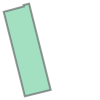

In [165]:
address_polygon

In [166]:
address_info['polygon'] = polygon
address_info['address_polygon'] = address_polygon

In [168]:
address_info

{'address': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
 'x_value': 153087.56,
 'y_value': 209564.97,
 'latitude': 51.19605343957527,
 'longitude': 4.412926986228825,
 'street': 'Sint-Hubertusstraat',
 'house_number': '89',
 'postcode': 2600,
 'municipality': 'Antwerpen',
 'polygon': [[153093.57102139294, 209554.90101145208],
  [153088.04794938862, 209576.96968346462],
  [153086.6291333884, 209576.6253634654],
  [153086.7168133855, 209576.27758746594],
  [153081.55226938426, 209574.8868674636],
  [153081.82017338276, 209573.81653146446],
  [153086.96302139014, 209553.26702744886],
  [153093.57102139294, 209554.90101145208]],
 'address_polygon': <shapely.geometry.polygon.Polygon at 0x21ad5848b50>}

### Figure out which tiff file to open depending on the coordinates

Alright! We are making good progress here! Now we have to figure out which tiff file to open depending on the coordinates.

To check which tiff file to open, we need to get the boundingbox of the tiff file and then compare if the X and Y of the address is inside the bounding box.

I was able to create a csv file containing the bounding box for all the DSM files. SO we just need to open it and check which tiff file should we use.

In [169]:
bbox = pd.read_csv('data/bounding-box.csv')

In [170]:
bbox.head()

,DSM Files,Left (X),Bottom (Y),Right (X),Top (Y)
0,DSM_1,145000.0,238000.0,162000.0,247000.0
1,DSM_2,162000.0,238000.0,194000.0,250000.0
2,DSM_3,194000.0,238000.0,206000.0,248000.0
3,DSM_4,53000.0,218000.0,66000.0,225500.0
4,DSM_5,66000.0,218000.0,98000.0,232000.0


In [172]:
for i in range(bbox.shape[0]):
    if bbox['Left (X)'][i] <= address_info['x_value']:
        if bbox['Right (X)'][i] >= address_info['x_value']:
            if bbox['Bottom (Y)'][i] <= address_info['y_value']:
                if bbox['Top (Y)'][i] >= address_info['y_value']:
                    num = i
                    break

In [173]:
bbox.iloc[num]

DSM Files       DSM_15
Left (X)      130000.0
Bottom (Y)    198000.0
Right (X)     162000.0
Top (Y)       218000.0
Name: 14, dtype: object

Now that we're able to locate from which tiff file the coordinates is located, we can now start using only this specific tiff files.

In [174]:
# Getting the DSM link
if num < 9:
    DSM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k0{num+1}.zip"
else:
    DSM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k{num+1}.zip"


In [175]:
# Getting the DTM link
if num < 9:
    DTM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k0{num+1}.zip"
else:
    DTM = f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k{num+1}.zip"

In [176]:
files = {'DSM': DSM, 'DTM': DTM}
files

{'DSM': 'https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k15.zip',
 'DTM': 'https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k15.zip'}

In [22]:
for key, value in files.items():
    with urlopen(value) as zipresp:
        print(f"Downloading the {key} zip file......")
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            print(f"Extracting the {key} zip file .......")
            zfile.extractall(f'data/raster-files/{key}')
            print(f"Done extracting the {key} zip file to raster-files/{key} folder! :)")

Extracting the DSM zip file .......
Done extracting the DSM zip file to raster-files/DSM folder! :)
Extracting the DTM zip file .......
Done extracting the DTM zip file to raster-files/DTM folder! :)


### Creating the Canopy Height Model

Alright! Now the DSM and DTM files are already saved and extracted to the `raster-files` folder.
We can now proceed in creating the <b>Canopy Height Model<b>.

`Canopy Height Model = DSM - DTM`

First, we have to open the tiff file from the extracted files and we need to use the mask option to only show the polygon inside the tiff file.

In [177]:
#Getting the DSM file
if num < 9:
    DSM_file = f'data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_k0{num+1}.tif'
else:
    DSM_file = f'data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_k{num+1}.tif'  

In [178]:
#Getting the DTM file
if num < 9:
    DTM_file = f'data/raster-files/DTM/GeoTiff/DHMVIIDTMRAS1m_k0{num+1}.tif'
else:
    DTM_file = f'data/raster-files/DTM/GeoTiff/DHMVIIDTMRAS1m_k{num+1}.tif'

In [179]:
DSM_file

'data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_k15.tif'

In [180]:
DTM_file

'data/raster-files/DTM/GeoTiff/DHMVIIDTMRAS1m_k15.tif'

In [181]:
address_info

{'address': 'Sint-Hubertusstraat 89, 2600 Antwerpen',
 'x_value': 153087.56,
 'y_value': 209564.97,
 'latitude': 51.19605343957527,
 'longitude': 4.412926986228825,
 'street': 'Sint-Hubertusstraat',
 'house_number': '89',
 'postcode': 2600,
 'municipality': 'Antwerpen',
 'polygon': [[153093.57102139294, 209554.90101145208],
  [153088.04794938862, 209576.96968346462],
  [153086.6291333884, 209576.6253634654],
  [153086.7168133855, 209576.27758746594],
  [153081.55226938426, 209574.8868674636],
  [153081.82017338276, 209573.81653146446],
  [153086.96302139014, 209553.26702744886],
  [153093.57102139294, 209554.90101145208]],
 'address_polygon': <shapely.geometry.polygon.Polygon at 0x21ad5848b50>}

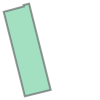

In [187]:
address_info['address_polygon']

In [185]:
with rt.open(DSM_file) as f:
    dsm_image, dsm_transform = rt.mask.mask(f, address_info['polygon'], crop=True)
    dsm_extent = rt.plot.plotting_extent(f)
    dsm_meta = f.meta

AttributeError: 'list' object has no attribute 'get'

# Playground

In [192]:
DSM_file

'data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_k15.tif'

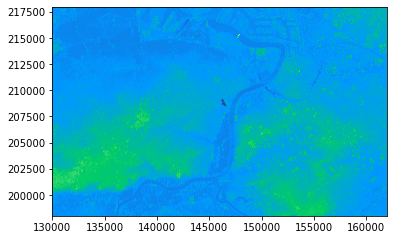

<AxesSubplot:>

In [202]:

# Read the data
data = rt.open(DSM_file)

# Visualize the NIR band
show((data, 1), cmap='terrain')

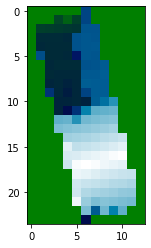

In [257]:
plt.imshow(CHM, cmap='ocean')
plt.show()

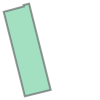

In [203]:
address_info['address_polygon']

In [209]:
poly = [{'coordinates': [[[153093.57102139294, 209554.90101145208],
   [153088.04794938862, 209576.96968346462],
   [153086.6291333884, 209576.6253634654],
   [153086.7168133855, 209576.27758746594],
   [153081.55226938426, 209574.8868674636],
   [153081.82017338276, 209573.81653146446],
   [153086.96302139014, 209553.26702744886],
   [153093.57102139294, 209554.90101145208]]],
 'type': 'Polygon'}]

In [211]:
poly

[{'coordinates': [[[153093.57102139294, 209554.90101145208],
    [153088.04794938862, 209576.96968346462],
    [153086.6291333884, 209576.6253634654],
    [153086.7168133855, 209576.27758746594],
    [153081.55226938426, 209574.8868674636],
    [153081.82017338276, 209573.81653146446],
    [153086.96302139014, 209553.26702744886],
    [153093.57102139294, 209554.90101145208]]],
  'type': 'Polygon'}]

In [212]:

out_img, out_transform = mask(dataset=data, shapes=poly, crop=True)

In [213]:
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 32000, 'height': 20000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 130000.0,
       0.0, -1.0, 218000.0)}


In [214]:
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

31370


In [218]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": epsg_code
                })

In [222]:
with rt.open("data/DSM_masked.tif", "w", **out_meta) as dest:
        dest.write(out_img)

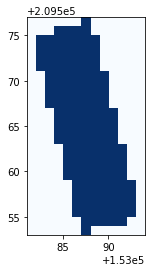

<AxesSubplot:>

In [246]:
dsm_tif = rt.open("data/DSM_masked.tif")

# Visualize
show((dsm_tif, 1), cmap='Blues')

In [240]:
# Read the data
data_dtm = rt.open(DTM_file)


out_img_dtm, out_transform_dtm = mask(dataset=data_dtm, shapes=poly, crop=True)
out_meta_dtm = data_dtm.meta.copy()
print(out_meta_dtm)

out_meta_dtm.update({"driver": "GTiff",
                 "height": out_img_dtm.shape[1],
                 "width": out_img_dtm.shape[2],
                 "transform": out_transform_dtm,
                 "crs": epsg_code
                })

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 32000, 'height': 20000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 130000.0,
       0.0, -1.0, 218000.0)}


In [241]:
with rt.open("data/DTM_masked.tif", "w", **out_meta_dtm) as dest:
        dest.write(out_img_dtm)

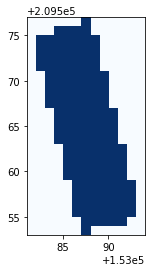

<AxesSubplot:>

In [247]:
dtm_tif = rt.open("data/DTM_masked.tif")

# Visualize
show((dtm_tif, 1), cmap='Blues')

In [248]:
CHM = dsm_tif - dtm_tif

TypeError: unsupported operand type(s) for -: 'DatasetReader' and 'DatasetReader'

In [249]:
dsm_tiff = rt.open("data/DSM_masked.tif")
dsm_array = dsm_tiff.read(1) #reading the 1st band
dsm_array

array([[-9999.  , -9999.  , -9999.  , -9999.  , -9999.  , -9999.  ,
           21.39, -9999.  , -9999.  , -9999.  , -9999.  , -9999.  ,
        -9999.  ],
       [-9999.  , -9999.  , -9999.  ,    14.68,    13.35,    14.97,
           21.38, -9999.  , -9999.  , -9999.  , -9999.  , -9999.  ,
        -9999.  ],
       [-9999.  ,    14.98,    15.07,    15.21,    15.35,    15.49,
           22.07,    22.09, -9999.  , -9999.  , -9999.  , -9999.  ,
        -9999.  ],
       [-9999.  ,    15.95,    15.92,    15.93,    16.08,    22.02,
           22.22,    22.14, -9999.  , -9999.  , -9999.  , -9999.  ,
        -9999.  ],
       [-9999.  ,    16.04,    15.98,    16.  ,    15.98,    22.03,
           22.2 ,    22.28, -9999.  , -9999.  , -9999.  , -9999.  ,
        -9999.  ],
       [-9999.  ,    21.73,    16.  ,    15.98,    16.04,    18.99,
           22.19,    22.09, -9999.  , -9999.  , -9999.  , -9999.  ,
        -9999.  ],
       [-9999.  , -9999.  ,    16.02,    15.92,    15.9 ,    15.94,
  

In [250]:
dtm_tiff = rt.open("data/DTM_masked.tif")
dtm_array = dtm_tiff.read(1) #reading the 1st band
dtm_array

array([[-9999.       , -9999.       , -9999.       , -9999.       ,
        -9999.       , -9999.       ,    11.88     , -9999.       ,
        -9999.       , -9999.       , -9999.       , -9999.       ,
        -9999.       ],
       [-9999.       , -9999.       , -9999.       ,    11.879514 ,
           11.875604 ,    11.876141 ,    11.876488 , -9999.       ,
        -9999.       , -9999.       , -9999.       , -9999.       ,
        -9999.       ],
       [-9999.       ,    11.85002  ,    11.860737 ,    11.85795  ,
           11.854791 ,    11.855257 ,    11.855593 ,    11.851808 ,
        -9999.       , -9999.       , -9999.       , -9999.       ,
        -9999.       ],
       [-9999.       ,    11.855274 ,    11.8687   ,    11.868029 ,
           11.86491  ,    11.862969 ,    11.8616295,    11.856451 ,
        -9999.       , -9999.       , -9999.       , -9999.       ,
        -9999.       ],
       [-9999.       ,    11.839546 ,    11.836151 ,    11.843951 ,
           11.848371

In [253]:
CHM = dsm_array - dtm_array
CHM

array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  9.509999 ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  2.8004866,  1.4743967,
         3.0938597,  9.503511 ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  3.1299791,  3.2092628,  3.3520498,  3.4952097,
         3.6347427, 10.214407 , 10.238193 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  4.0947256,  4.0513   ,  4.0619717,  4.21509  ,
        10.157031 , 10.35837  , 10.283548 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  4.2004547,  4.1438484,  4.156049 ,  4.131629 ,
        10.183989 , 10.354886 , 10.439555 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  9.903928 ,  4.177417 ,  4.151183 ,  4.2043066,
         7.157199 , 10.3580

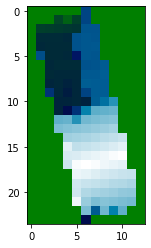

In [256]:
plt.imshow(CHM, cmap='ocean')
plt.show()

In [274]:
CHM

array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  9.509999 ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  2.8004866,  1.4743967,
         3.0938597,  9.503511 ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  3.1299791,  3.2092628,  3.3520498,  3.4952097,
         3.6347427, 10.214407 , 10.238193 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  4.0947256,  4.0513   ,  4.0619717,  4.21509  ,
        10.157031 , 10.35837  , 10.283548 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  4.2004547,  4.1438484,  4.156049 ,  4.131629 ,
        10.183989 , 10.354886 , 10.439555 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [ 0.       ,  9.903928 ,  4.177417 ,  4.151183 ,  4.2043066,
         7.157199 , 10.3580

In [272]:
polygon['coordinates']

[[153093.57102139294, 209554.90101145208],
 [153088.04794938862, 209576.96968346462],
 [153086.6291333884, 209576.6253634654],
 [153086.7168133855, 209576.27758746594],
 [153081.55226938426, 209574.8868674636],
 [153081.82017338276, 209573.81653146446],
 [153086.96302139014, 209553.26702744886],
 [153093.57102139294, 209554.90101145208]]

### Plotting 3D

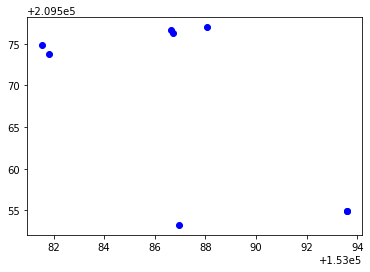

In [273]:
x = (153093.57102139294, 153088.04794938862, 153086.6291333884, 153086.7168133855, 153081.55226938426,
    153081.82017338276, 153086.96302139014, 153093.57102139294 )  
  
y = (209554.90101145208, 209576.96968346462, 209576.6253634654, 209576.27758746594, 209574.8868674636,
    209573.81653146446, 209553.26702744886, 209554.90101145208) 
  
plt.scatter(x, y, c ="blue") 
  
# To show the plot 
plt.show() 

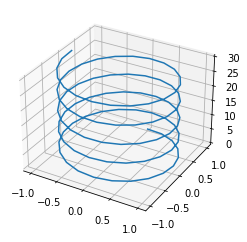

In [264]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection="3d")

z = np.linspace(0,30,100)
x = np.sin(z)
y = np.cos(z)

ax.plot3D(x,y,z)

plt.show()

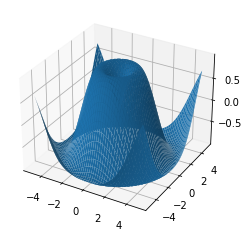

In [267]:
ax = plt.axes(projection="3d")

def z_function(x,y):
     return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)

X, Y = np.meshgrid(x,y)
Z = z_function(X,Y)

ax.plot_surface(X,Y,Z)

plt.show()

TypeError: plot() missing 1 required positional argument: 'ys'

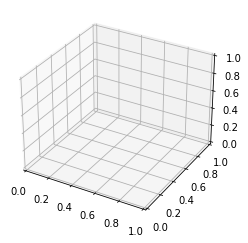

In [280]:

ax = plt.axes(projection="3d")

ax.plot3D(CHM)

plt.show()

In [292]:
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [291]:


#3D plot
#fliplr: Reverse the order of elements in 'crop_chm_img' array horizontally
fig = go.Figure(data=go.Surface(z=np.fliplr(CHM), colorscale='plotly3'))
fig.update_layout(scene_aspectmode='manual', scene_aspectratio=dict(x=1, y=1, z=0.5))
fig.update_layout(
    title={
        'text': "3D Building at " + formattedaddress,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    title_font_color="green")

fig.show()


NameError: name 'go' is not defined

In [ ]:

'''For plotting 3D'''

fig = go.Figure(data=go.Surface(z=crop_chm, colorscale='YlOrRd'))

fig.update_layout(title='3D Plot', autosize=True)

fig.show()

In [ ]:

fig = go.Figure(data=go.Surface(z=crop_img_chm, colorscale = 'YlGnBu'))
fig.show()

In [228]:
with rt.open(DSM_file) as f:
    dsm_image = rt.mask.mask(f, poly, crop=True)
    dsm_extent = rt.plot.plotting_extent(f)
    dsm_meta = f.meta

In [234]:
with rt.open(DTM_file) as f:
    dtm_image = rt.mask.mask(f, poly, crop=True)
    dtm_extent = rt.plot.plotting_extent(f)
    dtm_meta = f.meta

In [254]:
chm = dsm_image - dtm_image

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [ ]:
plt.imshow(chm, cmap='ocean')
plt.show()

Then, we can get the CHM.